## 1.11 Ensemble Methods

**Ensemble methods** combine the predictions of several base estimators built with a given learning algorithm, in order to improve generalizability / robustness over a single estimator.

There are two families of ensemble methods:
* **Averaging methods** (*e.g.* bagging methods, forests of randomized trees)
    * Principle is, build several estimators independently and average their predictions
    * This can reduce variance
* **Boosting methods** (*e.g.* AdaBoost, Gradient Tree Boosting)
    * Principle is, build the base estimators sequentially to reduce bias
    * Motivation is to combine several weak models to produce a powerful ensemble
    
***
###### *personal note - I like averaging more than boosting. It seems boosting requires you to be roughly right on the first iteration, and that's not guaranteed at all. Better to see if a bunch of models independently came to the same conclusion, rather than trust you can find the noisy signal with each guess*
***

### 1.11.1 Bagging meta-estimator

Bagging methods form a class of algorithms, which build several instances of a black-box estimator on random subset of the original training set, and then aggregates the individual instance predictions to produce a final prediction.

These methods reduce variance of a base estimator (*e.g.* a decision tree) by introducing randomness into its construction and then making an ensemble out of it.

Bagging methods tend to reduce overfitting, especially with strong and complex models (full DTs) whereas Boosting methods usually work better with weak models (shallow DTs).

Bagging methods differ in how they draw random subsets of the training data:
* **Pasting**
    * when random subsets of the dataset are drawn as random subsets of the *samples*
* **Bagging**
    * when samples are drawn with replacement
* **Random Subspaces**
    * when random subsets of the dataset are drawn as random subsets of the *features*
* **Random Patches**
    * when base estimators are built on subsets of both samples and features

Bagging methods in sklearn are offered as a unified `BaggingClassifier` or `BaggingRegressor` meta-estimator, taking a user-specified base estimator along with parameters for strategy to draw random subsets.

* `max_samples` and `max_features` control the size of the subsets
* `bootstrap` and `bootstrap_features` control whether subsets are drawn with replacement

When using a subset of available samples, the generalization accuracy can be estimated with the out-of-bag samples by setting `oob_score=True`

Example code for instantiating a Bagging ensemble of `KNeighborsClassifier` base estimators:

In [1]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)

###### Example - Single estimator bagging: bias-variance decomposition

This example compares the bias-variance decompoisition of the expected mean squared error of a single estimator against a bagging ensemble.

The expected MSE of an estimator can be decomposed in terms of **bias**, **variance**, and **noise**.

* **bias**
    * average amount by which estimator predictions differ from best possible estimator
* **variance**
    * measures variability of estimator predictions when fitting different instances
* **noise**
    * measures the irreducible part of the error due to data variability


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [4]:
#settings
n_repeat = 50 #number of iterations
n_train = 50 #size of training set
n_test = 1000 #size of test set
noise = 0.1 #standard deviation of noise
np.random.seed(0)

In [5]:
estimators = [('Tree', DecisionTreeRegressor()),
              ('BaggingTree', BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

In [9]:
#generate data
def f(x):
    x = x.ravel()
    
    return np.exp(-(x**2)) + 1.5 * np.exp(-((x-2) ** 2))

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)
    
    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))
        
        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)
        
    X = X.reshape((n_samples, 1))
    
    return X, y

In [10]:
X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)
    
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
BaggingTree: 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


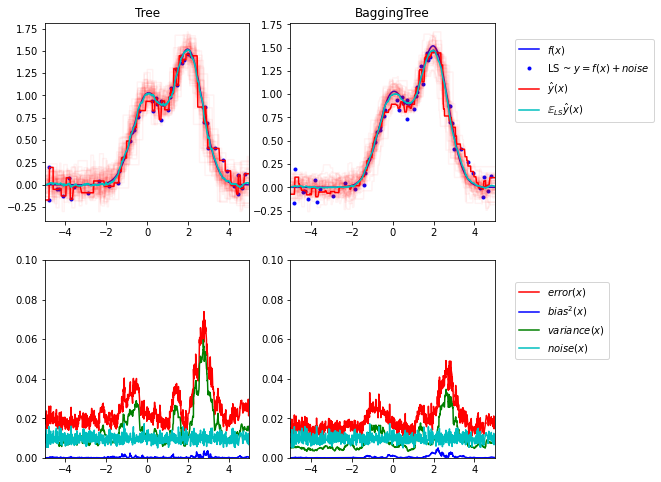

In [11]:
#copypasta
plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= n_repeat * n_repeat

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print(
        "{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
        " + {3:.4f} (var) + {4:.4f} (noise)".format(
            name, np.mean(y_error), np.mean(y_bias), np.mean(y_var), np.mean(y_noise)
        )
    )

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c", label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, 0.5))

plt.subplots_adjust(right=0.75)
plt.show()

### 1.11.2 Forests of randomized trees

The `sklearn.ensemble` module includes two averaging algorithms based on randomized DTs:
* $RandomForest$
* $ExtraTrees$

Both algorithms use perturb-and-combine techniques specifically designed for trees, which creates a diverse set of classifiers by introducing randoness in the classifier construction. The ensemble prediction represents the averaged predictions of the individual classifiers.

Like other classifiers, forest classifiers are fitted with two arrays:
* $X$ training samples of shape `(n_samples, n_features)`
* $Y$ target values of shape `(n_samples)`

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
X = [[0,0], [1,1]]
Y = [0,1]

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X,Y)

#### 1.11.2.1 Random Forests

1. In random forests (*e.g.* `RandomForestClassifier` and `RandomForestRegressor`), each tree in the ensemble is built from a sample drawn with replacement (*bootstrapped*) from the training set

2. Furthermore, when splitting each node during construction of a tree, the best split is either from all input features or a random subset of size `max_features`

**There are two sources of randomness because that decreases the variance of the forest estimator**

This is because individual DTs tend to overfit and have high variance. The injected randomness will yield DTs with decoupled prediction errors, and by taking an average of predictions with decoupled prediction errors you hope to cancel some errors out.

#### 1.11.2.2 Extremely Randomized Trees

In randomized trees (*e.g.* `ExtraTreesClassifier` and `ExtraTreesRegressor`), randomness goes one step further in the way splits are computed.

A random subset of candidate features is still used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule.

This usually reduces model variance, at the expense of an increase in model bias.

Example:

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [20]:
X, y = make_blobs(n_samples=10000, n_features=10, centers=100, random_state=0)

In [21]:
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)

scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9823000000000001

In [22]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None, 
                             min_samples_split=2, random_state=0)

scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9997

In [24]:
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, 
                           min_samples_split=2, random_state=0)

scores = cross_val_score(clf, X, y, cv=5)
scores.mean() > 0.999

True

###### Example - Plot the decision surfaces of ensembles of trees on the iris dataset
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html

#### 1.11.2.3 Parameters

The main parameters to adjust for these methods are 
* `n_estimators`
    * the number of trees in the forest
    * more trees gives better predictions but takes longer to compute
* `max_features`
    * size of random subsets of features
    * setting lower reduces variance but increases bias
    * defaults to `max_features=None` for regression
    * defaults to `max_features='sqrt'` for classification
    
It's recommended to start with settings like `max_depth=None` and `min_samples_split=2`, bearing in mind these are usually not optimal results. Best parameter values should **always** be cross validated.

Also note that bootstrap samples are used by default (`bootstrap=True`) in $Random Forests$, while the default for $ExtraTrees$ uses the whole dataset (`bootstrap='False'`)

When using bootstrap sampling, the generalization can be estimated on the left out or out-of-bag samples, enabled by setting `oob_score=True`

Also note the model grows on order $O(M*N*log(N))$ for $M$ trees and $N$ samples

#### 1.11.2.4 Parallelization

This module also features parallel tree construction and parallel computation of predictions through the `n_jobs` parameter. For `n_jobs=k` the computations are partitioned into $k$ jobs and run on $k$ cores of the machine. If `n_jobs=-1` then all cores available on the machine are used

The speedup for large $k$ might not be linear due to inter-process communication overhead.

###### Example - Plot the decision surfaces of ensembles of trees on the iris dataset
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html#sphx-glr-auto-examples-ensemble-plot-forest-iris-py

###### Example - Pixel importances with a parallel forest of trees

This example uses a forest of trees to evaluate impurity-based importance of the pixels in an image classification task on the faces dataset.

In [33]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import RandomForestClassifier

import time
import matplotlib.pyplot as plt

In [34]:
n_jobs = 1

#load faces dataset
data = fetch_olivetti_faces()

X, y = data.data, data.target

In [35]:
#limit the dataset to 5 classes
mask = y < 5

X = X[mask]
y = y[mask]

In [36]:
# a random forest classifier is fitted to compute feature importances
forest = RandomForestClassifier(n_estimators=750, n_jobs=n_jobs, random_state=42)

forest.fit(X,y)

RandomForestClassifier(n_estimators=750, n_jobs=1, random_state=42)

Feature importances are provided by the fitted attribute `feature_importances`

In [37]:
img_shape = data.images[0].shape
importances = forest.feature_importances_

imp_reshaped = importances.reshape(img_shape)

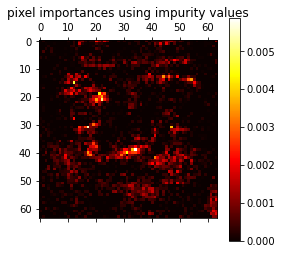

In [38]:
plt.matshow(imp_reshaped, cmap=plt.cm.hot)
plt.title('pixel importances using impurity values')
plt.colorbar()
plt.show()

###### Example - Face completion with multi-output estimators
(might be a repeat)

In [39]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

In [40]:
#load faces dataset, create train / test arrays
data, targets = fetch_olivetti_faces(return_X_y=True)

train = data[targets < 30]
test = data[targets >= 30] #test on independent people

In [41]:
#test on a subset of people
n_faces = 5

rng = check_random_state(4)

face_ids = rng.randint(test.shape[0], size=(n_faces,))
test = test[face_ids,:]

n_pixels = data.shape[1]

In [42]:
#copypasta
# Upper half of the faces
X_train = train[:, : (n_pixels + 1) // 2]
# Lower half of the faces
y_train = train[:, n_pixels // 2 :]
X_test = test[:, : (n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2 :]

In [43]:
#fit estimators
ESTIMATORS = {'ExtraTrees': ExtraTreesRegressor(n_estimators=10, 
                                                max_features=32,
                                                random_state=0),
             'KNN' : KNeighborsRegressor(),
             'LinReg' : LinearRegression(),
             'Ridge' : RidgeCV()}

In [44]:
#copypasta
y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)

# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2.0 * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

Text(0.5, 0.98, 'Face completion with multi-output estimators')

<Figure size 720x813.6 with 0 Axes>

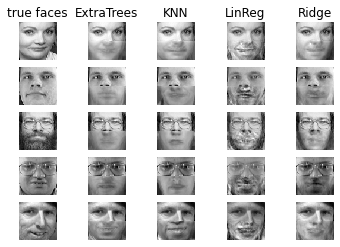

In [45]:
#copypasta
for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(
        true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest"
    )

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j, title=est)

        sub.axis("off")
        sub.imshow(
            completed_face.reshape(image_shape),
            cmap=plt.cm.gray,
            interpolation="nearest",
        )

plt.show()

#### 1.11.2.5 Feature importance evaluation

###### Example (repeat) - Pixel importances with a parallel forest of trees
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-faces-py

###### Example - Data generation and model fitting
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

#### 1.11.2.6 Totally Random Trees Embedding

`RandomTreesEmbedding` implements an unsupervised transformation of the data by using a forest of completely random trees and encoding the data ith the indices of the leaves it ends up in. This index is then encoded in a *one-of-$K$* manner, leading to a high dimensional and sparse binary coding.

This coding is computed very efficiently and then used as a basis for other learning tasks

###### Example - Hashing feature transformation using Totally Random Trees
https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_embedding.html#sphx-glr-auto-examples-ensemble-plot-random-forest-embedding-py

###### Example - Manifold learning on handwritten digits: Locally Linear Embedding, Isomap...
https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py

###### Example - Feature transformations with ensembles of trees
https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

### 1.11.3 AdaBoost

The popular `AdaBoost` algorithm was introduced in 1995. The core principle is to fit a sequence of *weak* learners (*i.e.* models that are only slightly better than random guessing) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted sum for the final prediction.

The modifications at each so-named *boosting iteration* are accomplished by applying weights $w_{1},w_{2},...,w_{n}$ to each of the training samples. The weights are initially weighted equally such that $w_{i}=1/N$ so that the first step trains a weak learner on the original data. For each successive iteration, the sample weights are modified and the learning algorithm is reapplied to the reweighted data.

At a given step, the training examples that were *incorrectly* predicted by the boosted model will have their weights *increased*. As iterations proceed, examples that are difficult to predict receive more and more influence, and each subsequent weak learner is forced to concentrate on examples that were missed in the previous iteration.

AdaBoost can be used for both classification and regression.

#### 1.11.3.1 Usage

Here's an example fitting AdaBoost classifier with 100 weak learners:

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

In [2]:
X, y = load_iris(return_X_y=True)

clf = AdaBoostClassifier(n_estimators=100)

scores = cross_val_score(clf, X,y,cv=5)
scores.mean()

0.9466666666666665

##### Some parameters:
* `n_estimators`
    * number of weak learners
* `learning_rate`
    * controls the contribution of weak learners in the final combination
* `base_estimator`
    * this allows you to specify different weak learners
* `max_depth` and `min_samples_split`
    * these control the complexity of the base estimator

###### Example - Discrete versus Real AdaBoost

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier

In [4]:
n_estimators = 100
learning_rate = 1.0

In [5]:
X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)

X_test, y_test = X[2000:], y[2000:]
X_train, y_train = X[:2000], y[:2000]

In [6]:
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

In [7]:
dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

In [8]:
ada_discrete = AdaBoostClassifier(base_estimator=dt_stump, 
                                 learning_rate=learning_rate,
                                 n_estimators=n_estimators,
                                 algorithm='SAMME')

ada_discrete.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=100)

In [9]:
ada_real = AdaBoostClassifier(base_estimator=dt_stump, 
                                 learning_rate=learning_rate,
                                 n_estimators=n_estimators,
                                 algorithm='SAMME.R')

ada_real.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=100)

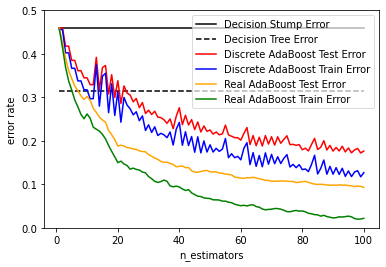

In [10]:
#copypasta
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, "k-", label="Decision Stump Error")
ax.plot([1, n_estimators], [dt_err] * 2, "k--", label="Decision Tree Error")

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

ax.plot(
    np.arange(n_estimators) + 1,
    ada_discrete_err,
    label="Discrete AdaBoost Test Error",
    color="red",
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_discrete_err_train,
    label="Discrete AdaBoost Train Error",
    color="blue",
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err,
    label="Real AdaBoost Test Error",
    color="orange",
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err_train,
    label="Real AdaBoost Train Error",
    color="green",
)

ax.set_ylim((0.0, 0.5))
ax.set_xlabel("n_estimators")
ax.set_ylabel("error rate")

leg = ax.legend(loc="upper right", fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

###### Example - Multi-class AdaBoosted Decision Trees

This example shows how boosting can improve prediction accuracy on a multi-class problem

In [11]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [12]:
X, y = make_gaussian_quantiles(n_samples=13000, n_features=10,
                              n_classes=3, random_state=1)

n_split = 3000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

In [13]:
bdt_real = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                              n_estimators=600, learning_rate=1)

In [14]:
bdt_discrete = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                                 n_estimators=600, learning_rate=1.5, algorithm='SAMME')

In [15]:
bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1.5, n_estimators=600)

In [16]:
real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
    bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(1.0 - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(1 - accuracy_score(discrete_train_predict, y_test))

In [17]:
n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

In [18]:
#copypasta
# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

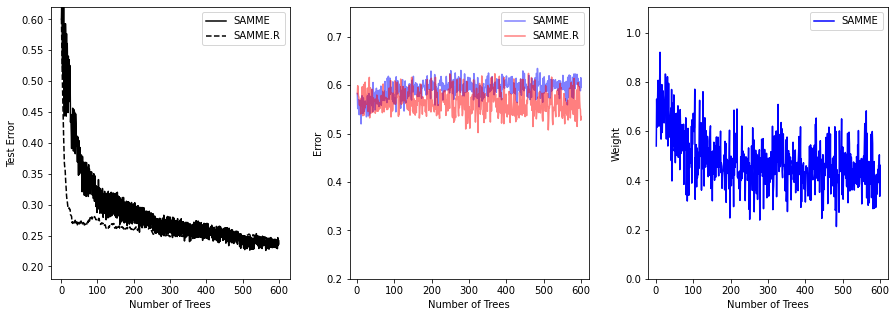

In [19]:
#copypasta
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1), discrete_test_errors, c="black", label="SAMME")
plt.plot(
    range(1, n_trees_real + 1),
    real_test_errors,
    c="black",
    linestyle="dashed",
    label="SAMME.R",
)
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel("Test Error")
plt.xlabel("Number of Trees")

plt.subplot(132)
plt.plot(
    range(1, n_trees_discrete + 1),
    discrete_estimator_errors,
    "b",
    label="SAMME",
    alpha=0.5,
)
plt.plot(
    range(1, n_trees_real + 1), real_estimator_errors, "r", label="SAMME.R", alpha=0.5
)
plt.legend()
plt.ylabel("Error")
plt.xlabel("Number of Trees")
plt.ylim((0.2, max(real_estimator_errors.max(), discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights, "b", label="SAMME")
plt.legend()
plt.ylabel("Weight")
plt.xlabel("Number of Trees")
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

###### Example - Two-class AdaBoost
https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-twoclass-py

###### Example - Decision Tree Regression with AdaBoost

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [21]:
#create the dataset
rng = np.random.RandomState(1)

X = np.linspace(0,6,100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

In [22]:
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

regr_1.fit(X,y)
regr_2.fit(X,y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x1B913408640)

In [23]:
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

In [24]:
import seaborn as sns

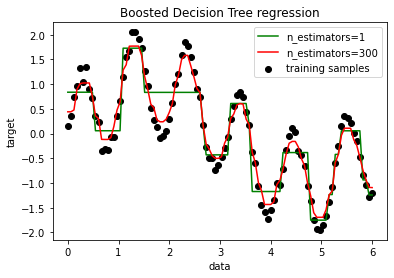

In [42]:
plt.figure()


plt.scatter(X,y, c='k', label='training samples')
plt.plot(X, y_1, c='g', label='n_estimators=1')
plt.plot(X,y_2, c='r', label='n_estimators=300')

plt.xlabel('data')
plt.ylabel('target')
plt.title('Boosted Decision Tree regression')

plt.legend()
plt.show()

### 1.11.4 Gradient Tree Boosting

**Gradient Tree Boosting** or **Gradient Boosted Decision Trees** (GBDT) is a generalization of boosting to arbitrary differentiable loss functions. It is an accurate and effective procedure used for both classification and regression in areas like web search ranking and ecology.

#### 1.1.4.1 Classification

Recall that the number of weak learners is controlled by `n_estimators`, and the size of each tree is controlled either by tree depth `max_depth` or number of leaf nodes `max_leaf_nodes`. The hyper-parameter `learning_rate` controls overfitting via shrinkage.

Example:

In [43]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

In [44]:
X, y = make_hastie_10_2(random_state=0)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

In [45]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.913

#### 1.11.4.2 Regression

`GradientBoostingRegressor` supports many different loss functions which are specified by the argument `loss`, and the default is `loss='squared_error'`

Example:

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)

X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]

In [4]:
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                               max_depth=1, random_state=0, loss='squared_error')

est.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=1, random_state=0)

In [5]:
mean_squared_error(y_test, est.predict(X_test))

5.009154859960321

###### Example - Gradient Boosting regression

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [7]:
#load data
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

In [8]:
#data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

params = {'n_estimators' : 500, 'max_depth' : 4,
          'min_samples_split' : 5, 'learning_rate' : 0.01,
          'loss' : 'squared_error'}

In [9]:
#fit regression model and find MSE
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))

print(f"MSE: {mse}")

MSE: 3011.474513785244


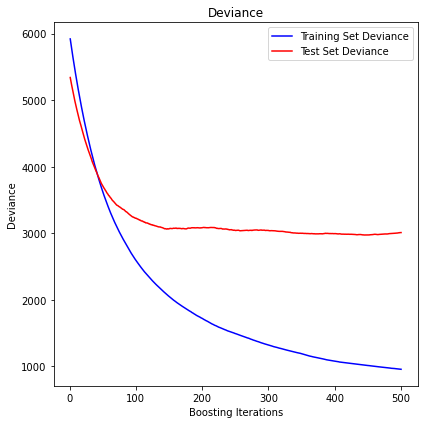

In [10]:
#copypasta
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

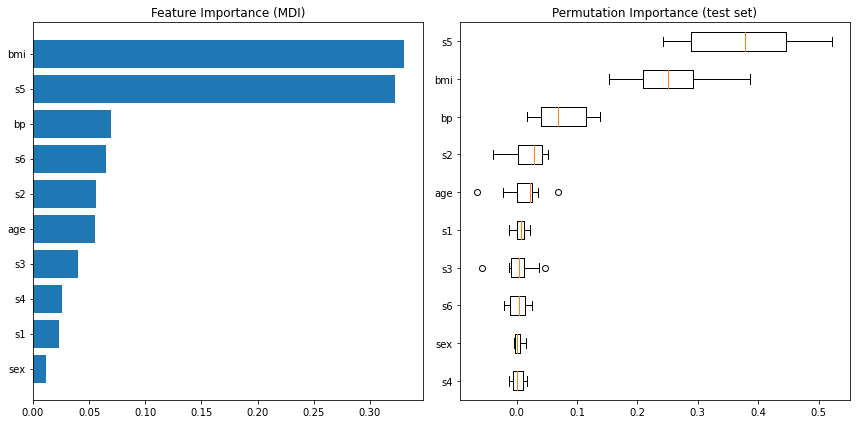

In [11]:
#copypasta
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(diabetes.feature_names)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

###### Example - Gradient Boosting Out-of-Bag estimates

Out-of-bag (OOB) estimates can be a useful heuristic to estimate the 'optimal' number of boosting iterations. OOB estimates are almost identical to cross-validation estimates but can be computed on the fly without the need for repeated model fitting.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.model_selection import KFold, train_test_split

from scipy.special import expit

In [13]:
#copypasta
# Generate data (adapted from G. Ridgeway's gbm example)
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

p = expit(np.sin(3 * x1) - 4 * x2 + x3)
y = random_state.binomial(1, p, size=n_samples)

X = np.c_[x1, x2, x3]

X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=9)


In [15]:
#fit classifier with OOB estimates
params = {"n_estimators": 1200, "max_depth": 3,
    "subsample": 0.5, "learning_rate": 0.01,
    "min_samples_leaf": 1, "random_state": 3,}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

acc = clf.score(X_test, y_test)
print(f"Accuracy: {acc}")

Accuracy: 0.684


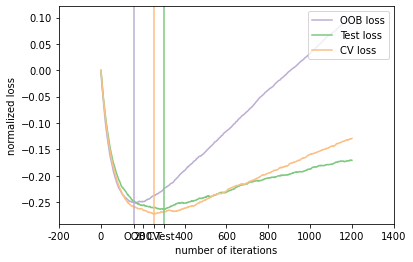

In [16]:
#copypasta
n_estimators = params["n_estimators"]
x = np.arange(n_estimators) + 1


def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``."""
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score


def cv_estimate(n_splits=None):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        cv_clf.fit(X_train[train], y_train[train])
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_splits
    return val_scores


# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)

# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

# color brew for the three curves
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# plot curves and vertical lines for best iterations
plt.plot(x, cumsum, label="OOB loss", color=oob_color)
plt.plot(x, test_score, label="Test loss", color=test_color)
plt.plot(x, cv_score, label="CV loss", color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# add three vertical lines to xticks
xticks = plt.xticks()
xticks_pos = np.array(
    xticks[0].tolist() + [oob_best_iter, cv_best_iter, test_best_iter]
)
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) + ["OOB", "CV", "Test"])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc="upper right")
plt.ylabel("normalized loss")
plt.xlabel("number of iterations")

plt.show()

#### 1.11.4.4 Controlling the tree size

The size of regression tree base learners defines the level of variable interactions that can be captured by the gradient boosting model. In general, a tree of depth $h$ can capture interactions of order $h$

If you specify `max_depth=h` then complete binary trees of depth $h$ will be grown, and such trees will have at most $2^{h}$ leaf nodes and $2^{h}-1$ split nodes

The other method to control tree size is by specifying number of leaf nodes with `max_leaf_nodes`, so trees are grown using best-first search where nodes with highest improvement in impurity will be expanded first. A tree with `max_leaf_nodes=k` has $k-1$ split nodes, and can model interactions of up to order `max_leaf_nodes - 1`

#### 1.11.4.5 Mathematical formulation
##### 1.11.4.5.1 Regression
##### 1.11.4.5.2 Classification

#### 1.11.4.6 Loss Functions
The following `loss=` functions are supported:
* Regression
    * `'squared_error'`
        * **Squared error** is a natural choice for regression due to its superior computational properties. Initial model is given by the mean of target values
    * `'lad'`
        * **Least absolute deviation** is a robust loss function, with the initial model given by the median of target values
    * `'huber'`
        * **Huber** is another loss function that combines least squares and least absolute deviation
    * `'quantile'`
        * **Quantile** loss function for quantile regression. Use $0<\alpha<1$ to specify the quantile
* Classification
    * `'deviance'`
        * **Binomial deviance** is the binomial negative log-likelihood loss function for binary classification. Initial model is given by the log odds-ratio
    * `'deviance'`
        * **Multinomial deviance** is the multinomial negative log-likelihood loss function for multiclass classification with `n_classes` mutually exclusive classes. Inefficient for datasets with a large number of classes
    * `'exponential'`
        * **Exponential** loss function, same as `AdaBoostClassifier`. Less robust to mislabeled examples than `'deviance'` and can only be used for binary classification

#### 1.11.4.7 Shrinkage via learning rate
#### 1.11.4.8 Subsampling

###### Example - Gradient Boosting regularization
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regularization.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regularization-py
###### Example - Gradient Boosting Out-of-Bag Estimates
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_oob.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-oob-py
###### Example - OOB Errors for Random Forests
https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py

#### 1.11.4.9 Interpretation with feature importance
Individual decision trees can be interpreted by visualizing the tree structure. Gradient boosting models comprise hundreds of regression trees, and are thus not easily interpreted by visual inspection

The feature importance of a fit gradient boosting model is accessed using `feature_importances_`

Example:

In [18]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
X, y = make_hastie_10_2(random_state=0)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0).fit(X,y)

clf.feature_importances_

array([0.10684213, 0.10461707, 0.11265447, 0.09863589, 0.09469133,
       0.10729306, 0.09163753, 0.09718194, 0.09581415, 0.09063242])